# Performance Analysis - CUDA
> Number of effective sequences implemented in CUDA
- toc: true
- branch: master
- badges: true
- author: Donatas Repečka
- categories: [performance]

## Introduction

In [the previous post](https://donatasrep.github.io/donatas.repecka/performance/2021/04/27/Performance-comparison.html) I have compared various languages and libraries in terms of their speed. This notebook contains a version of CUDA that has CUDA kernels to perform the calculations. 


As a test case, we will use calculation of effective sequences (Nf) in the MSA. Just to remind the pseudo code looks like this:

```
for seq1 in seqs:
  for seq2 in seqs:
    if count_mathes(seq1, seq2) > threshold:
      weight +=1
  meff += 1/weight
 
meff = meff/(len(seq1)^0.5)
```

Just note, that algorithmic complexity is ```O(n*log(n))``` or ```O(n^2)``` depending on implementation.

A reminder of speeds for 2500 sequences of MSA length 683.

| Library  | Time (ms)| Time (ms)| 
|----------|----------|----------|
|   Numpy  | Singlethreaded | 2000 | 
|   Numba  | Multithreaded |   669    | 
|   Numpy  | Multithreaded |   503    |  
| Pytorch  | GPU      | 389 |
|   Numba  | Multithreaded + Low precision |   176    | 
|   Jax    |   GPU    |   116    |

\* [Why is JAX so fast?](https://github.com/google/jax/discussions/11078)

Import  to note that a lot of of ideas were taken from Heremy Howard's lectures: 
* https://www.youtube.com/watch?v=nOxKexn3iBo
* https://www.youtube.com/watch?v=eUuGdh3nBGo

## Setup

In [1]:
# ! wget https://raw.githubusercontent.com/donatasrep/donatas.repecka/master/data/picked_msa.fasta

In [2]:
# ! pip install numpy
# ! pip install pandas
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ! pip install  wurlitzer ninja

In [3]:
import pandas as pd
import numpy as np
import torch

## Getting data

In [4]:
def get_data(path):
    fasta_df = pd.read_csv(path, lineterminator=">", header=None)
    fasta_df[['id', 'seq']] = fasta_df[0].str.split('\n', expand=True)[[0,1]]
    return fasta_df.seq.to_numpy(dtype=str)
seqs = get_data('picked_msa.fasta')

In [5]:
seqs[:2]

array(['QRVAMDMHLRHMQYKMPDNYRGYQWRYDFPTIWIMQGGEGRINLTIPRAAPRKIQYQPNYAKTSPEYTMILRGAKPHATLRRDTGARNPCTYPWVQPRRPNKKPGQVDSLPNTDRLMNVKLNMDAHPQNPVPSVRRYGRPPYHTWSQNRDRKDIFFCRLRHPQYTPRFIFMWLDPMEGAYGTRQWQLRPTGFKVYPQRFDMIRHLDRIDFLATHPDRARRTSNDDRRRIIQYMRDCTTGQLIRRTQRGVRGSLIYIKKITACTKTNKSRGSRRKMGTLWRQMILKMQNEGTPQPKQPLTRLMFRGQIGFCLRWAPGFIMEIIPRSPRQKQGQRFVWGPDTTKISTMAKTIRRQIPIRGRPDRQKPFMRFNDMKTGSIKGNRQTKRGPWLLPNISRYKKRDPNIIGWPPCRLENIIAINRQKDIGKRQEGTPRNARIPHINMIRNKTPPDLWRYVILEQHSTIRRRDQDLNTFGPNNIRVPIQRRPRPMMGRTHVCRDARIMIHGQLPDRQDTPRPDIDHQWSQDGYYRRTMGTLKIGIINQQMQMNAWIKIRPIGQYITLIMRAIRQTIRKEIMGKKRVNSQDYLSIFIQIHAHGMASLLLGRRQYMGKMAKVKDMARIRRKIRFRPKLRYAAHCPGHTKGHYIMILGVLEIDTIILKIIAQMQPDQYQRRAMVYYPVYLRAV',
       'QRVRMDMSLRSMQYIMPMIYPGYQWRYDFPTIWIMQGGEGRINLTIPRAAPRKIQYQPNYAKTSPEYTMILRGAKPHATLRRDTGARNPCTYPWVQPRRPNKKPGQVDSLPNTDRLMNVKLNMDAHPQNPVPSVRRYGRPPYHLWSQNRDRKDIFFCRLRHPQYTPRFIFMWLDPGEGAYGTRQWQLRPTGFKVYPQRFDMIRHLDRIDFLATHPDRARRTSNDDARRIIQYMRDCTTGQLIRRRQRGVRGSLIYIKKITRCTKTNKSRGSRRKMGTLWRQMILKMQNEGTPQPKQPL

## Python

* Each GPU consists of several Streaming Multiprocessors (SM). In case of RTX 3090 - we have of them 82.
* Each SM contains CUDA cores. In case of RTX 3090 - we have 128 of them.
* That adds up to 10496 CUDA cores which is roughly equal number of operations that can be run in parallel. 

Interestingly, A100 has only 6912 CUDA cores.

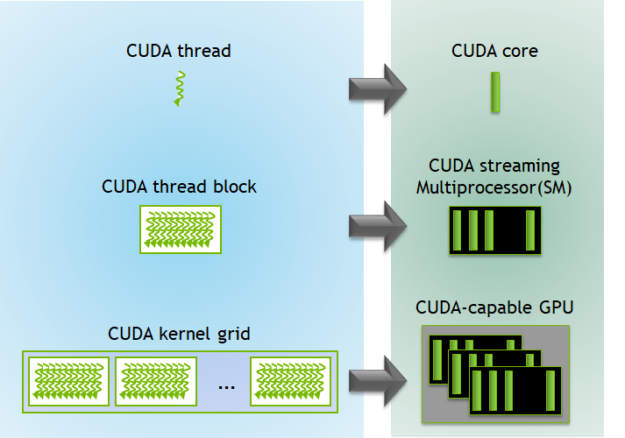

Source: https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/

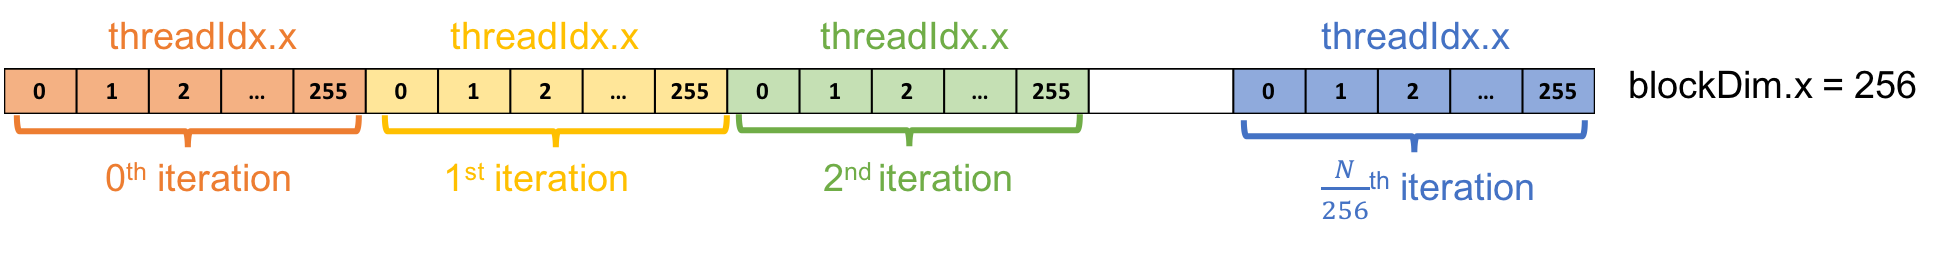

Source: https://cuda-tutorial.readthedocs.io/en/latest/tutorials/tutorial02/

Here, we will write CUDA simulator in python, it is slow, but makes it easier to develop.

In [6]:
from collections import namedtuple
dim3 = namedtuple('dim3', ['x','y','z'], defaults=(1,1))

In [7]:
def cdiv(a,b):
    "Int ceiling division of `a` over `b`"
    return (a+b-1)//b

In [8]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(dim3(i1,i0), dim3(j1,j0), threads, *args)

In [9]:
def get_nf(blockIdx, threadIdx, blockDim, seqs, out, n_seqs, seq_len):
    id1 = blockIdx.y*blockDim.y + threadIdx.y
    id2 = blockIdx.x*blockDim.x + threadIdx.x

    if (id1>=n_seqs or id2>=n_seqs): return
 
    seq1 = seqs[id1]
    seq2 = seqs[id2]
    identity = 0
    
    for p in range(seq_len):
        identity = identity + int(seq1[p] == seq2[p])
    identity = identity/seq_len

    is_more = identity > 0.8

    out[id1 * n_seqs + id2] = is_more
    out[id2 * n_seqs + id1] = is_more
    

In [10]:
def nf_2d(seqs):
    n_seqs  = seqs.shape[0]
    seq_len = len(seqs[0])
    output = torch.zeros((n_seqs, n_seqs), dtype=float)
    tpb = dim3(16,16)
    blocks = dim3(cdiv(n_seqs, tpb.x), cdiv(n_seqs, tpb.y))
    blk_kernel2d(get_nf, blocks, tpb, seqs, output.flatten(), n_seqs, seq_len)
    return output

### Testing

In [11]:
python_mask = nf_2d(seqs[:100])
python_nf = (1/ python_mask.sum(-1)).sum() / (len(seqs[0])**0.5)
python_nf

tensor(0.1801, dtype=torch.float64)

In [12]:
%%timeit
python_mask = nf_2d(seqs[:100])

797 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CUDA

Once we have python version, we need to translate this to CUDA/C++ code. 

In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']='0'
from torch.utils.cpp_extension import load_inline

In [14]:
%load_ext wurlitzer

In [15]:
def load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=False, name=None):
    "Simple wrapper for torch.utils.cpp_extension.load_inline"
    if name is None: name = funcs[0]
    flags = "-O3 -Xptxas -O3 -Xcompiler -O3" if opt else "-O0 -Xptxas -O0 -Xcompiler -O0"
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=[flags], verbose=verbose, name=name)

In [16]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)
#define CUDA_ERR(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
__host__ __device__ inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a+b-1)/b;}
'''

In [17]:
cuda_src = cuda_begin + r'''

__device__ float get_identity(uint8_t* seq1, uint8_t* seq2, int seq_len) {
    float identity = 0.0f;
    for (int p = 0; p < seq_len; ++p) {
        identity += (seq1[p] == seq2[p]) ? 1 : 0;
    }
    return identity / seq_len;
}

__global__ void nf_kernel(uint8_t* seqs, uint8_t* out, int n_seqs, int seq_len) {
    int id1 = blockIdx.y * blockDim.y + threadIdx.y;
    int id2 = blockIdx.x * blockDim.x + threadIdx.x;

    if (id1 >= n_seqs || id2 >= n_seqs) return;

    uint8_t* seq1 = &seqs[id1 * seq_len];
    uint8_t* seq2 = &seqs[id2 * seq_len];

    float identity = get_identity(seq1, seq2, seq_len);

    bool is_more = identity > 0.8f;

    out[id1 * n_seqs + id2] = is_more;
    out[id2 * n_seqs + id1] = is_more;
}

torch::Tensor get_nf(torch::Tensor input) {
    CHECK_INPUT(input);
    int n_seqs = input.size(0);
    int seq_len = input.size(1);
    auto output = torch::empty({n_seqs,n_seqs}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(n_seqs,tpb.x), cdiv(n_seqs,tpb.y));
    nf_kernel<<<blocks, tpb>>>(
        input.data_ptr<uint8_t>(), output.data_ptr<uint8_t>(), n_seqs, seq_len);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [18]:
module = load_cuda(cuda_src, "torch::Tensor get_nf(torch::Tensor input);", ['get_nf'], verbose=True)

Using /home/drepecka/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/drepecka/.cache/torch_extensions/py311_cu121/get_nf/build.ninja...
Building extension module get_nf...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module get_nf...


In [19]:
def get_nf_cuda(seqs):
    seqs = torch.from_numpy(seqs.view(np.int32).reshape(seqs.shape[0], -1)).byte().contiguous().cuda()
    cuda_mask = module.get_nf(seqs)
    cuda_nf = (1/cuda_mask.sum(-1)).sum() / (len(seqs[0])**0.5)
    return cuda_nf.item()

In [20]:
cuda_nf = get_nf_cuda(seqs[:2500])
np.testing.assert_almost_equal(cuda_nf, 19.919439, decimal=4)

In [31]:
%%timeit -n 3 -r 3
get_nf_cuda(seqs[:2500])

115 ms ± 9.06 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Numba with CUDA

Numba also allows us to access CUDA and write kernels even without leaving python

In [22]:
os.environ['NUMBA_ENABLE_CUDASIM']='0'

In [23]:
from numba import cuda
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce GTX 1650 Ti'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-3f8cf4e0-90bd-e695-da8e-354107ab341b
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [24]:
from numba import cuda
@cuda.jit
def nf_kernel(seqs, out, seq_len, h):

    id1 = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    id2 = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if (id1 >= h or id2 >= h): return

    seq1 = seqs[id1]
    seq2 = seqs[id2]


    identity = 0
    for p in range(seq_len):
        identity += (seq1[p] == seq2[p])
    identity = identity / seq_len


    is_more = identity > 0.8

    out[id1, id2] = is_more
    out[id2, id1] = is_more

In [25]:
def get_nf_numba(seqs):
    h = seqs.shape[0]
    tpb = dim3(16,16)
    blocks = dim3(cdiv(h,tpb.x), cdiv(h,tpb.y))
    seqs_cuda_numba = cuda.to_device(seqs.view(np.int32).reshape(h, -1).astype(np.byte))
    out = cuda.to_device(np.zeros((h, h), dtype=np.byte))
    nf_kernel[blocks, tpb](seqs_cuda_numba, out, len(seqs[0]), h)
    numba_nf = sum(1/out.copy_to_host().sum(1))/len(seqs[0])**0.5
    return numba_nf 

In [26]:
nf_numba_cuda = get_nf_numba(seqs[:2500])
np.testing.assert_almost_equal(nf_numba_cuda, 19.919439, decimal=4)

In [30]:
%%timeit -n 3 -r 3
get_nf_numba(seqs[:2500])

124 ms ± 7.06 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


While Numba is slower, it may be enough for a large number of pratical applications. 

## Summary

Now we have these speeds for 2500 sequences of MSA length 683.

| Library  | Time (ms)| Time (ms)| 
|----------|----------|----------|
|   Numpy  | Singlethreaded | 2000 | 
|   Numba  | Multithreaded |   669    | 
|   Numpy  | Multithreaded |   503    |  
| Pytorch  | GPU      | 389 |
|   Numba  | Multithreaded + Low precision |   176    | 
|   Jax    |   GPU    |   116    |
|   CUDA    |   GPU    |   115    |
|   Numba (CUDA)    |   GPU    |   124    |

While this is may not be the most representative case, it still gives some intuition on potential speed improvements. Definitely, pure python is slow, however, I see python as a interface to other languages through various libraries (Numpy, Numba, Jax, Polars). By utilising these libraries, you benefit from well-tested and optimised code, which could take time to achieve when doing from scratch (for example, in C/Rust, etc). In most cases, with some thinking, the problem at hand can be converted to fit the framework of the library. If that does not work or if you really need to optimise every microsecond, then going the lowest level will be always (almost) fastest solution performance wise. 
